In [15]:
import matplotlib.pyplot as plt
import numpy as np
from mibitrans.analysis.mass_balance import mass_balance
from mibitrans.data.parameter_information import ElectronAcceptors
from mibitrans.data.parameters import AttenuationParameters
from mibitrans.data.parameters import HydrologicalParameters
from mibitrans.data.parameters import ModelParameters
from mibitrans.data.parameters import SourceParameters
from mibitrans.transport.models import Bioscreen
from mibitrans.transport.models import Mibitrans
from mibitrans.visualize.plot_line import centerline
from mibitrans.visualize.plot_surface import plume_3d
from mibitrans.visualize.show_mass_balance import visualize_mass_balance

In [16]:
ft = 3.281 # factor to convert ft to m

This example compares the Domenico (1987) analytical solution as implemented in the original BIOSCREEN with the exact solution described in Karanovic et al. (2007), implemented in BIOSCREEN-AT. The solution from Karanovic is adapted as follows:

\begin{equation}
C(x,y,z,t)  \sum_{i=1}^{n}\left(C^*_{0,i}\frac{x}{8\sqrt{\pi D^{'}_{x}}}\exp(-\gamma t)
\cdot \int_{0}^{t}\left[\frac{1}{\tau^{\frac{3}{2}}} \exp\left((\gamma - \lambda_{EFF})\tau - \frac{(x-v^{'}\tau)^2}{4D^{'}_{x}\tau}\right)
\cdot \left\{ERFC\left(\frac{y-Y_i}{2 \sqrt{D^{'}_{y}\tau}}\right)-ERFC\left(\frac{y+Y_i}{2 \sqrt{D^{'}_{y}\tau}}\right) \right\}
\cdot \left\{ERFC\left(\frac{z-Z}{2 \sqrt{D^{'}_{z}\tau}}\right)-ERFC\left(\frac{z+Z}{2 \sqrt{D^{'}_{z}\tau}}\right) \right\}\right] d\tau \right)
\end{equation}

Which allows for source superposition and therefore multiple source zones. For instant reaction, BC is added to the outer source zone and subtracted from the resulting concentrations. Where (C(x,y,z,t) < 0) = 0

## Input parameters
Input parameters are the default parameters when opening up BIOSCREEN-AT. All imperial units are converted to consistent metric units.


In [17]:
hydro = HydrologicalParameters(
    # Groundwater flow velocity, in [m/day]
    velocity=335.2 / ft / 365,
    # Effective soil porosity [-]
    porosity=0.25,
    # Longitudinal dispersivity, in [m]
    alpha_x=28.887 / ft,
    # Transverse horizontal dispersivity, in [m]
    alpha_y=2.889 / ft,
    # Transverse vertical dispersivity, in [m]
    alpha_z=0.289 / ft,
)

# Parameters for retardation and degradation
att = AttenuationParameters(
    # Contaminant retardation factor [-]
    retardation=1.20672,
    # Contaminant half life, in [days]
    half_life=0,
)

# Parameters for source dimensions and concentrations
source = SourceParameters(
    # Extent of source in the positive y-direction (total source extent is 2*50=100
    source_zone_boundary=np.array([50 / ft]),
    # Concentration in source zone
    source_zone_concentration=np.array([9]),
    # Source extent in z-direction
    depth=10 / ft,
    # Undissolved mass of contaminant source
    total_mass="inf",
)

model = ModelParameters(
    # Model extent in the longitudinal (x) direction in [m].
    model_length=2500 / ft,
    # Model extent in the transverse horizontal (y) direction in [m].
    model_width=500 / ft,
    # Model duration in [days].
    model_time=5 * 365,
    # Model grid discretization step size in the longitudinal (x) direction, in [m].
    dx=20 / ft,
    # Model grid discretization step size in the transverse horizontal (y) direction, in [m].
    dy=5 / ft,
    # Model time discretization step size, in [days]
    dt=365,
)

# Make object for electron acceptor concentration to use for instant reaction model
ea=ElectronAcceptors(
    # Difference between background oxygen and current oxygen concentration in groundwater, in [g/m^3]
    delta_oxygen=5.78,
    # Difference between background nitrate and current nitrate concentration in groundwater, in [g/m^3]
    delta_nitrate=17,
    # Current ferrous iron concentration in groundwater, in [g/m^3]
    ferrous_iron=11.3,
    # Difference between background sulfate and current sulfate concentration in groundwater, in [g/m^3]
    delta_sulfate=100,
    # Current methane concentration in groundwater, in [g/m^3]
    methane=0.414,
)

## Running model
As the exact solution uses an integral, run time is longer than that of the Bioscreen solution, depending on model resolution. Using verbose when running the model is recommended, to keep track of the calculation process.

In [18]:
att.half_life = 0
mbt_nodecay = Mibitrans(
    hydrological_parameters=hydro,
    attenuation_parameters=att,
    source_parameters=source,
    model_parameters=model,
    verbose=True,
)
mbt_nodecay.run()

# Set half life to a non-0 value to simulate linear decay
att.half_life = 10 * 365

mbt_lindecay = Mibitrans(
    hydrological_parameters=hydro,
    attenuation_parameters=att,
    source_parameters=source,
    model_parameters=model,
    verbose=True,
)
mbt_lindecay.run()

mbt_instant = Mibitrans(
    hydrological_parameters=hydro,
    attenuation_parameters=att,
    source_parameters=source,
    model_parameters=model,
    verbose=True,
)
mbt_instant.instant_reaction(electron_acceptors=ea)
mbt_instant.run()

integrating for source zone  0  and t = 365 days
integrating for source zone  0  and t = 730 days
integrating for source zone  0  and t = 1095 days
integrating for source zone  0  and t = 1460 days
integrating for source zone  0  and t = 1825 days
integrating for source zone  0  and t = 365 days
integrating for source zone  0  and t = 730 days
integrating for source zone  0  and t = 1095 days
integrating for source zone  0  and t = 1460 days
integrating for source zone  0  and t = 1825 days
integrating for source zone  0  and t = 365 days
integrating for source zone  0  and t = 730 days
integrating for source zone  0  and t = 1095 days
integrating for source zone  0  and t = 1460 days
integrating for source zone  0  and t = 1825 days


## Visualize

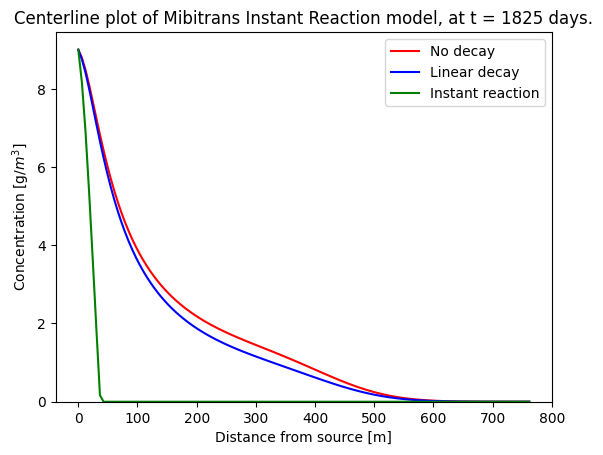

In [19]:
centerline(mbt_nodecay, color="red", label="No decay")
centerline(mbt_lindecay, color="blue", label="Linear decay")
centerline(mbt_instant, color="green", label="Instant reaction")
plt.legend()
plt.show()

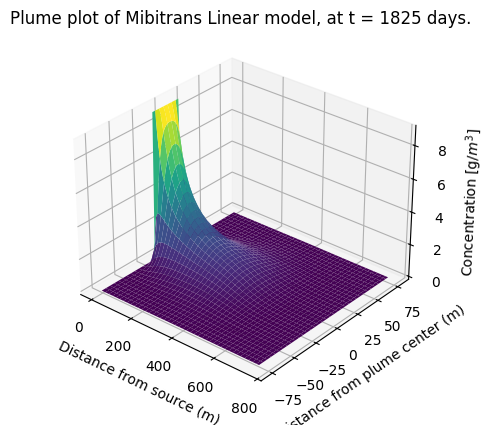

In [20]:
plume_3d(mbt_nodecay, cmap="viridis")
plt.show()

Running Bioscreen solution for comparison

In [21]:
att.half_life = 0
bio_nodecay = Bioscreen(
    hydrological_parameters=hydro,
    attenuation_parameters=att,
    source_parameters=source,
    model_parameters=model,
    verbose=True,
)
bio_nodecay.run()

# Set half life to a non-0 value to simulate linear decay
att.half_life = 10 * 365

bio_lindecay = Bioscreen(
    hydrological_parameters=hydro,
    attenuation_parameters=att,
    source_parameters=source,
    model_parameters=model,
    verbose=True,
)
bio_lindecay.run()

bio_instant = Bioscreen(
    hydrological_parameters=hydro,
    attenuation_parameters=att,
    source_parameters=source,
    model_parameters=model,
    verbose=True,
)
bio_instant.instant_reaction(electron_acceptors=ea)
bio_instant.run()

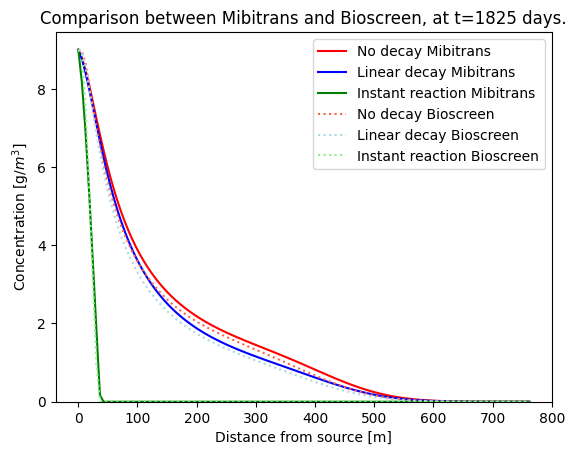

In [25]:
centerline(mbt_nodecay, color="red", label="No decay Mibitrans")
centerline(mbt_lindecay, color="blue", label="Linear decay Mibitrans")
centerline(mbt_instant, color="green", label="Instant reaction Mibitrans")
centerline(bio_nodecay, color="tomato", linestyle=":", label="No decay Bioscreen")
centerline(bio_lindecay, color="lightblue", linestyle=":", label="Linear decay Bioscreen")
centerline(bio_instant, color="lightgreen", linestyle=":", label="Instant reaction Bioscreen")
plt.title("Comparison between Mibitrans and Bioscreen, at t=1825 days.")
plt.legend()
plt.show()

## Comparing to BIOSCREEN-AT


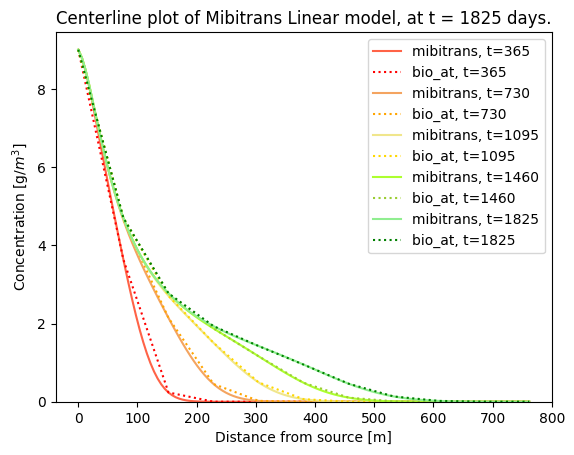

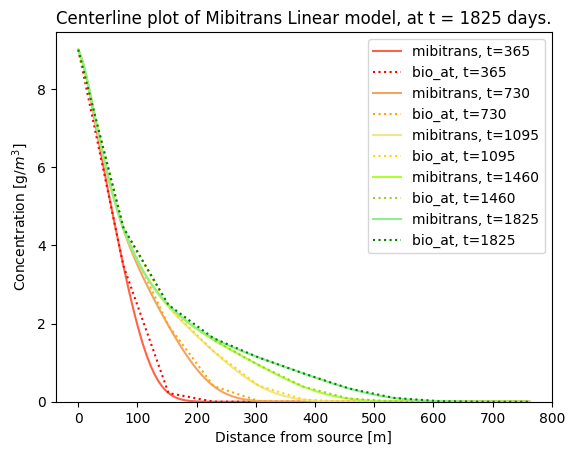

In [23]:
bio_x = [0, 250 / ft, 500 / ft, 750 / ft, 1000 / ft, 1250 / ft, 1500 / ft, 1750 / ft, 2000 / ft, 2250 / ft, 2500 / ft]
bio_at_nodecay = np.array(
    (
        [
            [9.000, 3.635, 0.236, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
            [9.000, 4.649, 2.144, 0.452, 0.022, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
            [9.000, 4.696, 2.707, 1.505, 0.493, 0.064, 0.003, 0.000, 0.000, 0.000, 0.000],
            [9.000, 4.699, 2.767, 1.872, 1.161, 0.483, 0.104, 0.010, 0.000, 0.000, 0.000],
            [9.000, 4.699, 2.772, 1.932, 1.423, 0.947, 0.459, 0.134, 0.021, 0.002, 0.000],
        ]
    )
)

bio_at_lindecay = np.array(
    (
        [
            [9.000, 3.479, 0.222, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
            [9.000, 4.407, 1.944, 0.401, 0.019, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
            [9.000, 4.448, 2.423, 1.289, 0.412, 0.053, 0.002, 0.000, 0.000, 0.000, 0.000],
            [9.000, 4.450, 2.471, 1.580, 0.938, 0.380, 0.081, 0.008, 0.000, 0.000, 0.000],
            [9.000, 4.450, 2.475, 1.624, 1.131, 0.721, 0.340, 0.097, 0.015, 0.001, 0.000],
        ]
    )
)
colors = ["tomato", "sandybrown", "khaki", "greenyellow", "lightgreen"]
colors_bio = ["red", "orange", "gold", "yellowgreen", "green"]
for i in range(len(mbt_nodecay.t)):
    centerline(mbt_nodecay, time=mbt_nodecay.t[i], color=colors[i], label=f"Mibitrans, t={mbt_nodecay.t[i]}")
    plt.plot(bio_x, bio_at_nodecay[i, :], color=colors_bio[i], linestyle=":", label=f"bio_at, t={mbt_nodecay.t[i]}")
plt.legend()
plt.show()


for i in range(len(mbt_lindecay.t)):
    centerline(mbt_lindecay, time=mbt_lindecay.t[i], color=colors[i], label=f"Mibitrans, t={mbt_lindecay.t[i]}")
    plt.plot(bio_x, bio_at_lindecay[i, :], color=colors_bio[i], linestyle=":", label=f"bio_at, t={mbt_lindecay.t[i]}")
plt.legend()
plt.show()

mibitrans output corresponds very well with the BIOSCREEN-AT output, and has higher resolution. Note that despite BIOSCREEN-AT taking in instant reaction parameters, it does not have the option to calculate biodegradation this way.

#### Mass balance for Mibitrans solution

Mass balance function also works with the Mibitrans solution. Note that because the resolution is usually coarser than the Domenico solution, due to the aforementioned increased run times, the error margin in the mass balance is increased as well.

In [24]:
mb = mass_balance(mbt_nodecay)
print(mb)
visualize_mass_balance(mb)

mb_dom = mass_balance(bio_nodecay)
visualize_mass_balance(mb_dom)


{'time': np.int64(1825), 'source_mass_0': 'infinite', 'source_mass_t': 'infinite', 'source_mass_change': np.float64(106767.19701799711), 'plume_mass_no_decay': np.float64(40940.479157296584), 'transport_outside_extent_nodecay': np.float64(65826.71786070053)}
MASS BALANCE FOR t = 1825
+---------------+----------+
|  Source decay | Mass (g) |
+---------------+----------+
|   mass t = 0  | infinite |
| mass t = 1825 | infinite |
|   delta mass  | 106767.2 |
+---------------+----------+
+---------------------------------------+----------+
|                No decay               | Mass (g) |
+---------------------------------------+----------+
|               plume mass              | 40940.5  |
| mass transported outside model extent | 65826.7  |
+---------------------------------------+----------+
MASS BALANCE FOR t = 1825
+---------------+----------+
|  Source decay | Mass (g) |
+---------------+----------+
|   mass t = 0  | infinite |
| mass t = 1825 | infinite |
|   delta mass  | 10676